<a href="https://colab.research.google.com/github/fire-long/24-1AI-ML/blob/main/W12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/24-1인공지능과기계학습

/content/drive/MyDrive/24-1인공지능과기계학습


## 8.3 주성분 분석

In [2]:
#데이터셋 생성을 위한 추가 코드
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3)) #3D data init
np.random.seed(42)
angles=(np.random.rand(m) ** 3 + 0.5) * 2 * np.pi#고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5 #타원형
X += 0.28 * np.random.randn(m, 3) #노이즈 추가
X = Rotation.from_rotvec([np.pi/29, -np.pi/20, np.pi/4]).apply(X)
X+=[0.2, 0, 0.2] #약간 이동

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [3]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [5]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser = 'auto') #futre warning을 안 뜨게 하고자 parser option 추가
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[:60_000], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # d == 154

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [8]:
pca.explained_variance_ratio_.sum()

0.9501960192613035

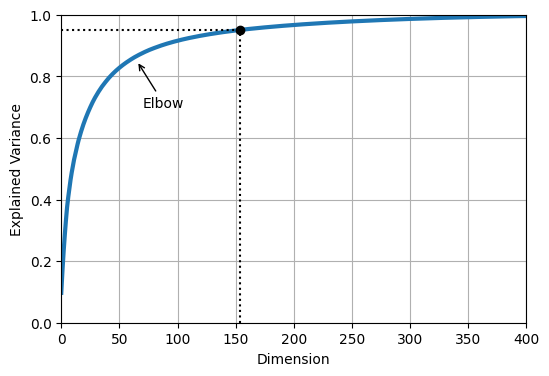

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimension")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy= (65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components":np.arange(10, 80),
    "randomforestclassifier__n_estimators":np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)

rnd_search.fit(X_train[:1000], y_train[:1000])
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [11]:
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [13]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [14]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train # 대신 반복을 사용해 데이터를 한 청크씩 저장 가능
X_mmap.flush()

ValueError: mmap length is greater than file size

In [15]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_incremental_pca.py:352: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio = S**2 / np.sum(col_var * n_total_samples)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_incremental_pca.py:352: RuntimeWarning: divide by zero encountered in divide
  explained_variance_ratio = S**2 / np.sum(col_var * n_total_samples)


IncrementalPCA(batch_size=600, n_components=154)

# 8.4 랜덤 투영

In [16]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=e)
d

7300

In [17]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n)/np.sqrt(d)#표준편차는 분산의 제곱근
X = np.random.randn(m,n) #가짜 데이터셋 생성
X_reduced = X@P.T

In [20]:
from sklearn.random_projection import GaussianRandomProjection
gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)#이전 결과와 동일

In [21]:
are_close = np.allclose(X_reduced, X_reduced_2, atol=1e-7)
are_close

NameError: name 'X_reduced_2' is not defined

In [23]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

# 8.5 지역 선형 임베딩

In [24]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

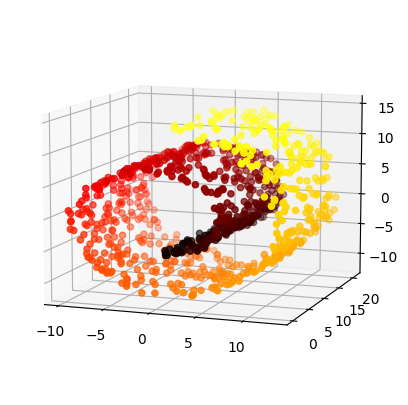

In [25]:
from matplotlib.colors import ListedColormap
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))
axes = [-11.5, 14, -2, 23, -12, 15]

fig=plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2],
           c=t, cmap=darker_hot)
ax.view_init(10, -70)
plt.show()

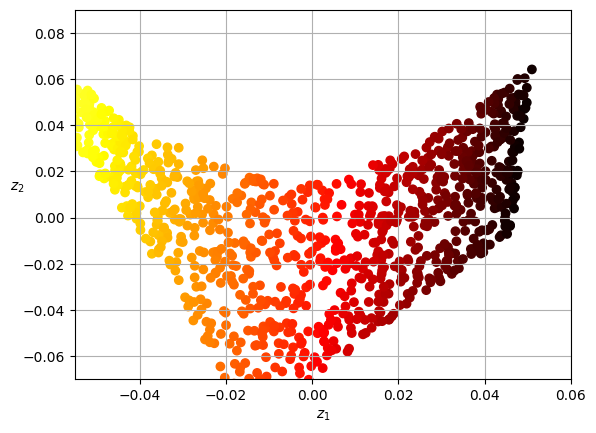

In [28]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
           c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.show()

# 연습문제 9. MNIST에 PCA 적용하기

## a.MNIST 데이터셋 로드, 훈련세트와 테스트세트로 분할.(처음 6만개는 훈련샘플, 나머지 1만개는 테스트용 샘플)

In [29]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

## b.이 데이터셋에 랜덤포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가함.

In [31]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf.fit(X_train, y_train)

CPU times: user 52.4 s, sys: 113 ms, total: 52.5 s
Wall time: 52.7 s


RandomForestClassifier(random_state=42)

In [32]:
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

## c. PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소하고, 해당 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인함. 훈련 속도가 빨라졌는가?

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 2min 15s, sys: 100 ms, total: 2min 15s
Wall time: 2min 15s


RandomForestClassifier(random_state=42)

## d. 테스트 세트에서 분류기 평가. 이전분류기와 비교하면?

In [36]:
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

## e. SGDClassifier로 다시 시도 시, PCA가 얼마나 도움되는가?

In [37]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 3min 21s, sys: 281 ms, total: 3min 22s
Wall time: 3min 23s


0.874

In [38]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

y_pred = sgd_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

CPU times: user 47.4 s, sys: 130 ms, total: 47.5 s
Wall time: 47.7 s


ValueError: X has 154 features, but SGDClassifier is expecting 784 features as input.

# 연습문제 10. MNIST에 t-SNE 적용하기

## a.t-SNE 알고리즘으로 MNIST 데이터셋을 2차원으로 축소시키고 matplotlib로 그래프 그리기. 이미지의 타깃 클래스마다 10가지 색상으로 나타낸 산점도를 그릴 수 있음.

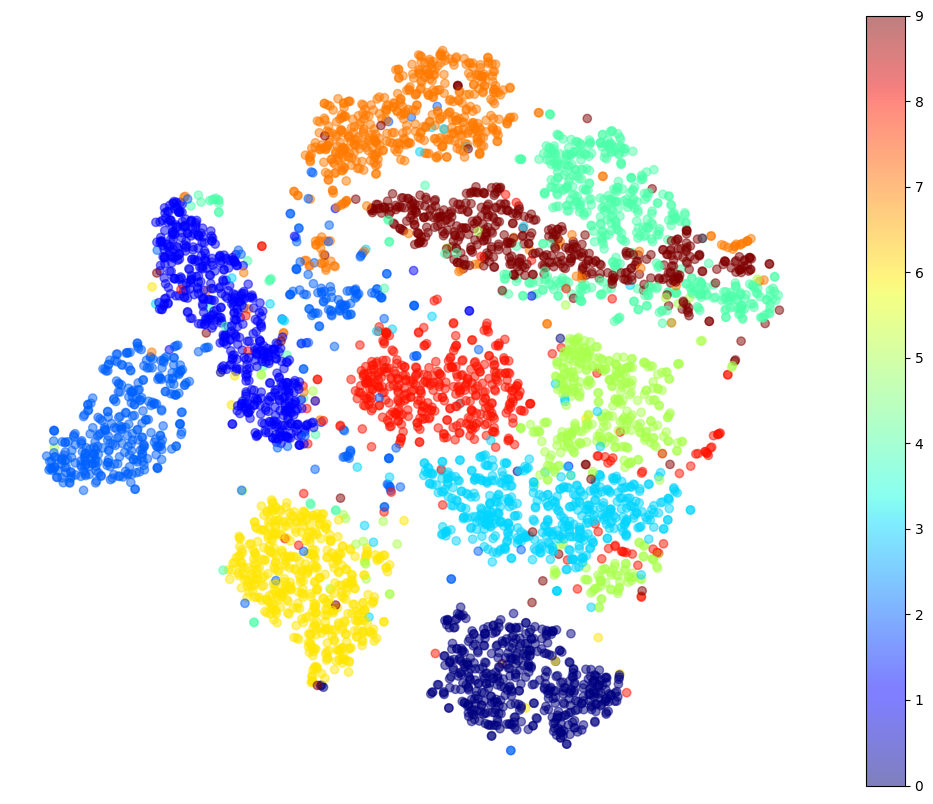

In [39]:
X_sample, y_sample = X_train[:5000], y_train[:5000]
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced = tsne.fit_transform(X_sample)
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

In [40]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
  X_normalized=MinMaxScaler().fit_transform(X)
  neighbors = np.array([[10., 10.]])
  plt.figure(figsize=figsize)
  plt.title("2010346 박진영")
  cmap = plt.cm.jet
  digits = np.unique(y)
  for digit in digits:
    plt.scatter(X_normalized[y==digit, 0], X_normalized[y==digit, 1],
                c=[cmap(float(digit)/9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()
    for index, image_coord in enumerate(X_normalized):
      closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
      if closest_distance>min_distance:
        neighbors=np.r_[neighbors, [image_coord]]
        if images is None:
          plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                   color=cmap(float(y[index])/9),
                   fontdict={'weight':'bold', 'size':16})
        else:
          image = images[index].reshape(28, 28)
          imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                    image_coord)
          ax.add_artist(imagebox)

In [41]:
import sys

#노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/fronted select Noninteractive'|debconf-set-selections
  #나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)
  #나눔바른곧기 폰트로 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  #마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font',family='NanumBarunGothic')

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


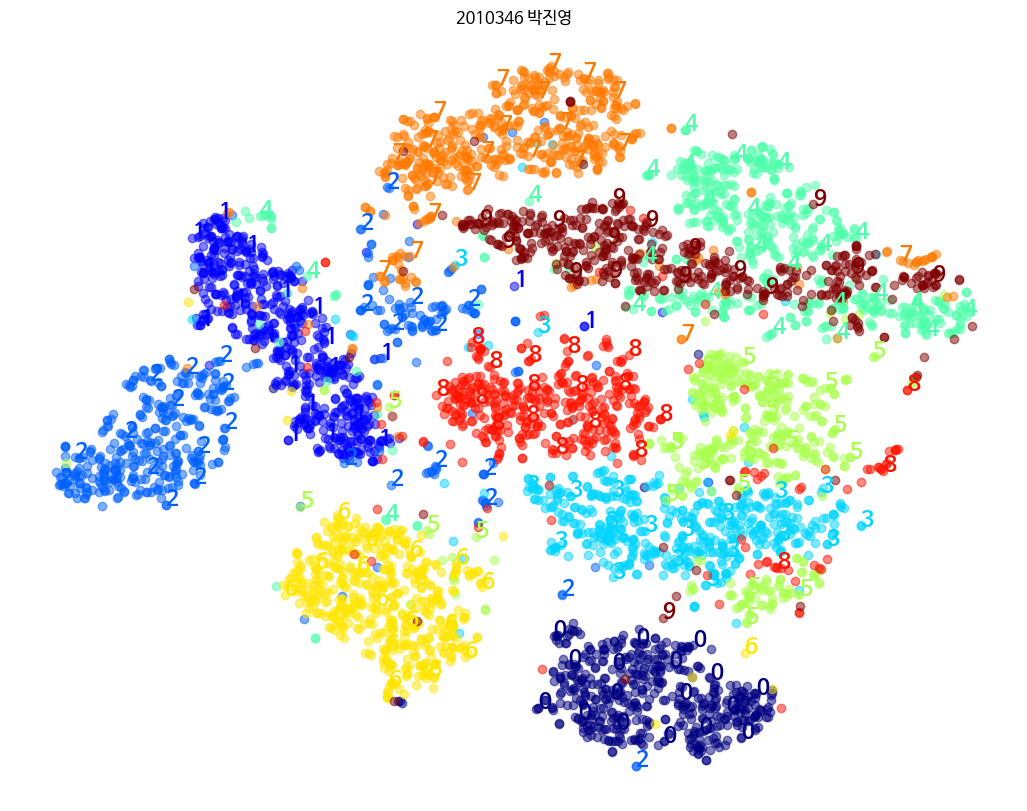

In [42]:
plot_digits(X_reduced, y_sample)

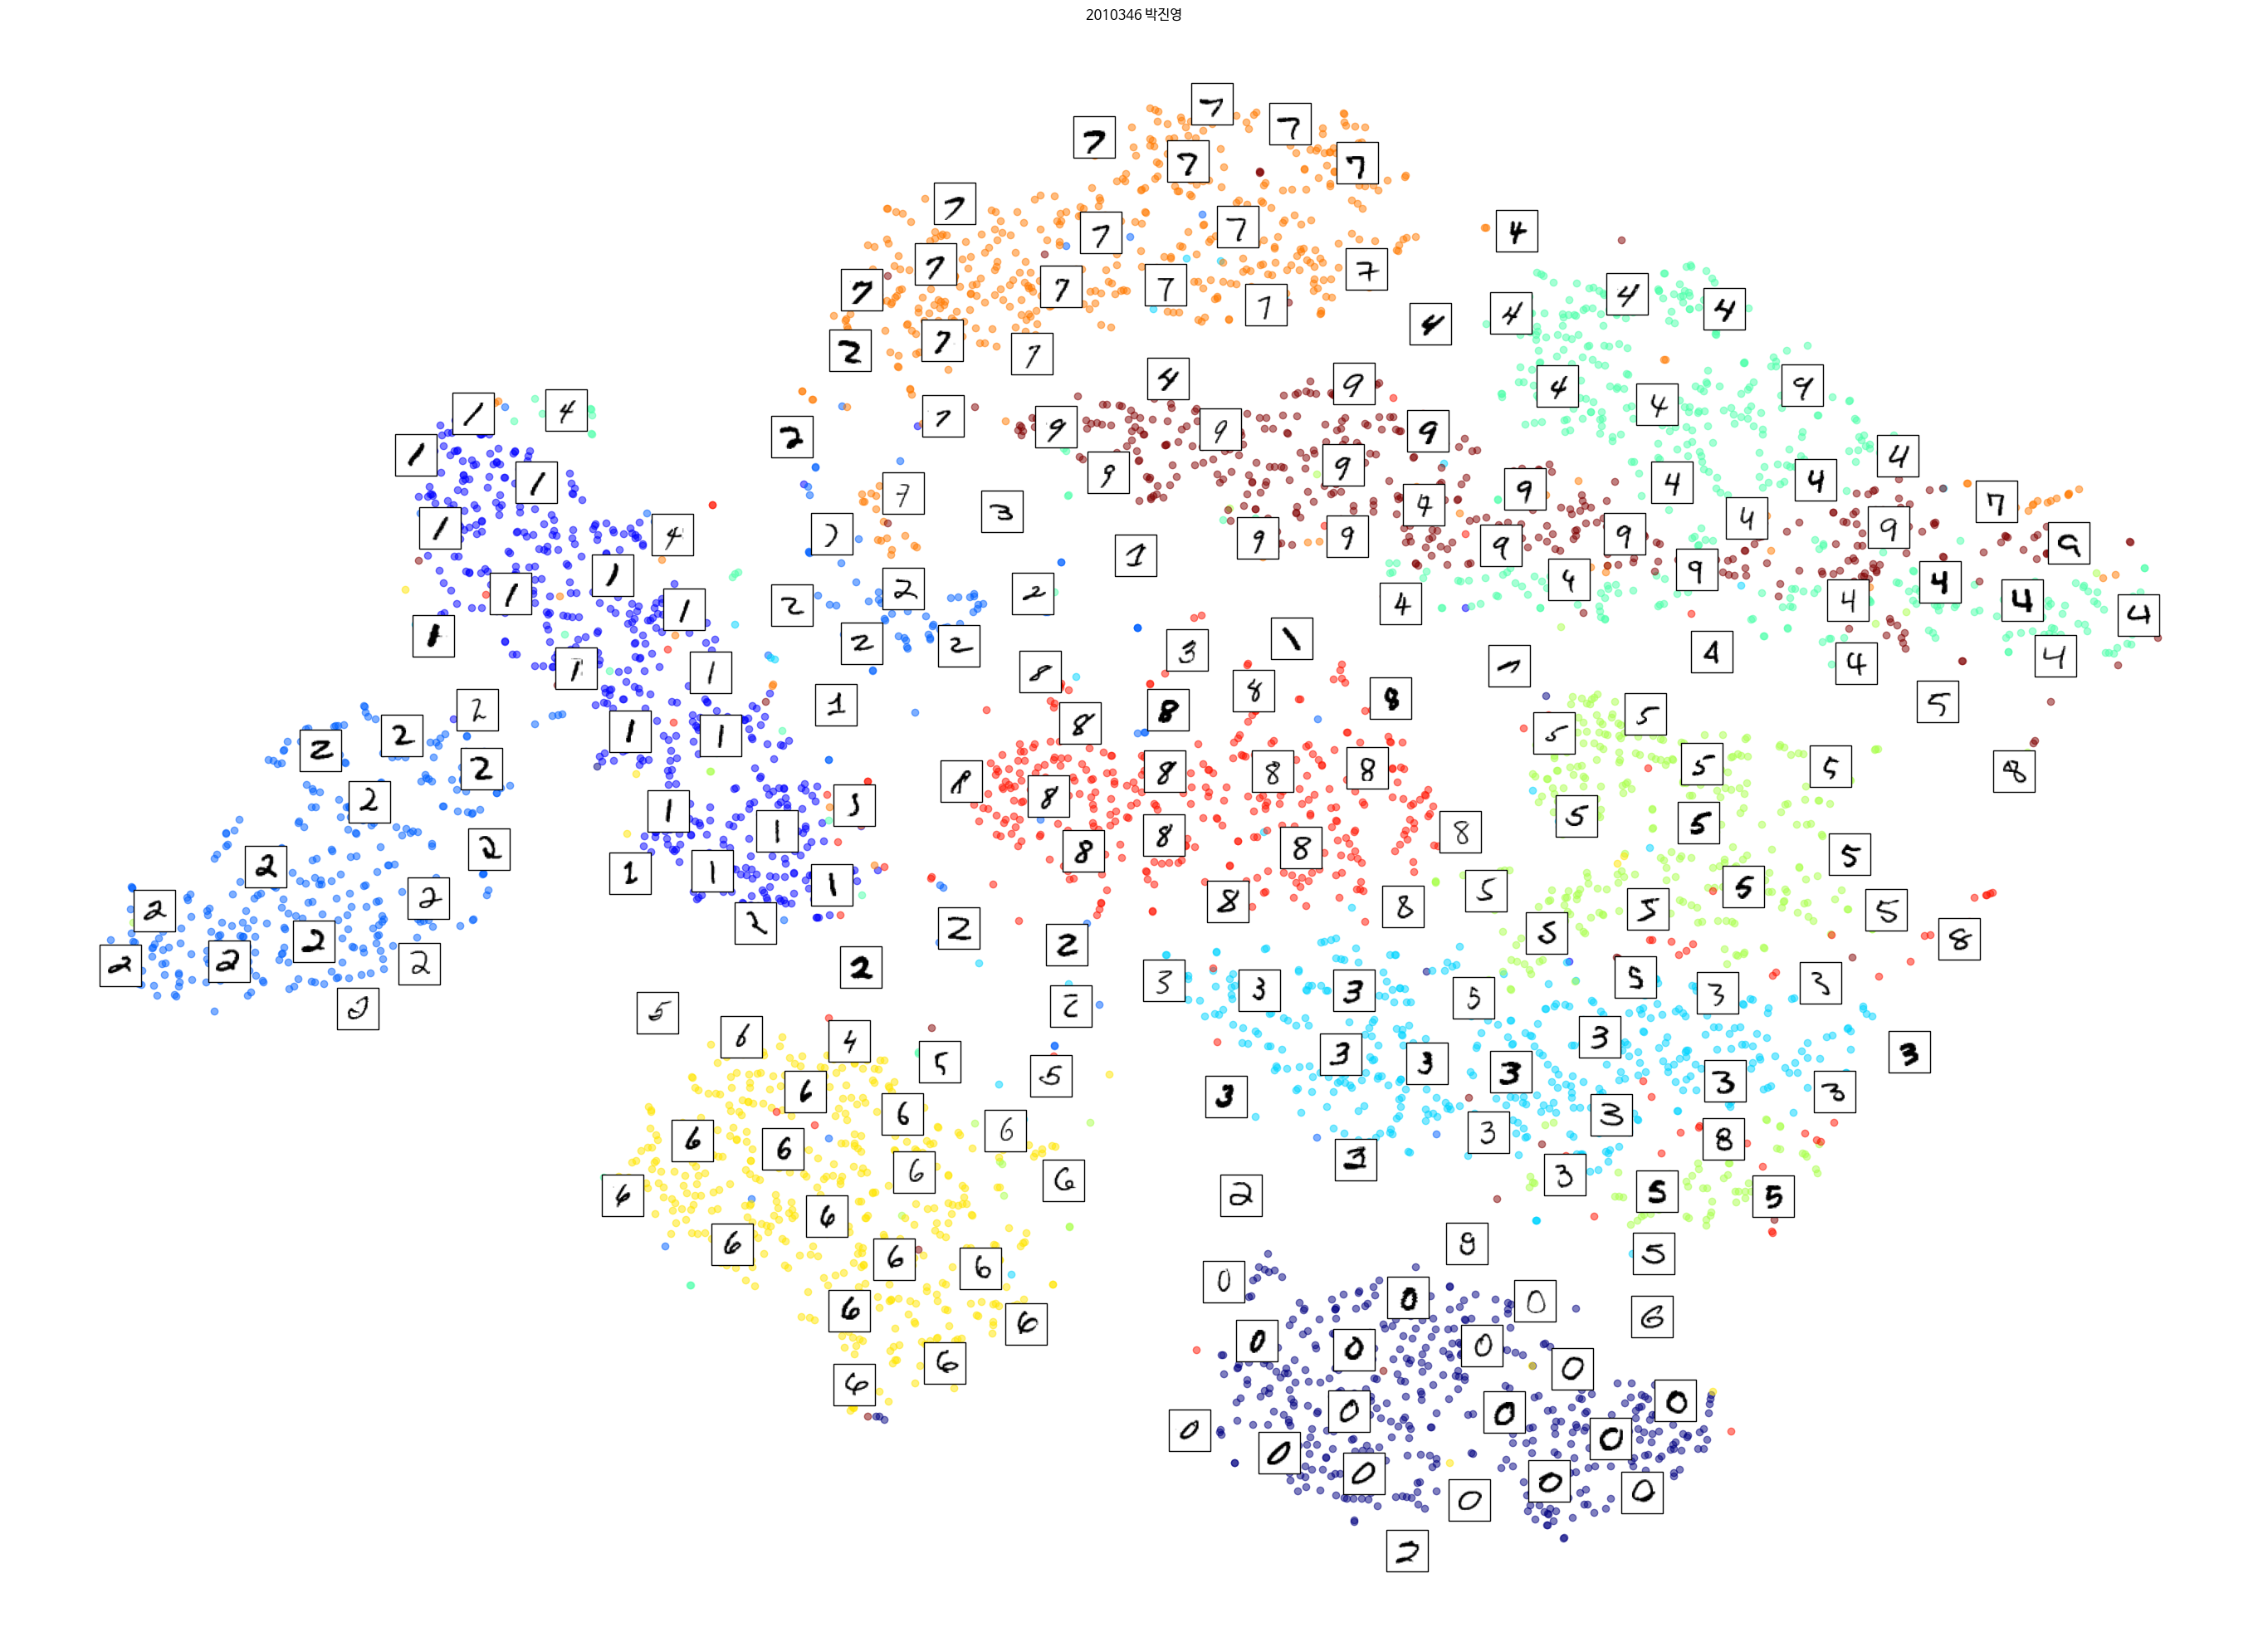

In [43]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))